In [49]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

In [50]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

In [51]:
from typing import Any ,List

General case:
- Choose a prior for $Z$: $p(Z)$.
- Choose an observation model: $p_\theta(X|Z)$
- Choose a variational posterior: $q_{\gamma}(\mathbf{z} | \mathbf{x})$

- Choose a missing model: $p_{\phi}(\mathbf{S} | \mathbf{X^o, X^m})$


The ELBO in the MNAR case is

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

### Classic case
The model we are building has a Gaussian prior and a Gaussian observation model (also the decoder ($z \rightarrow x$) ),

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p_\theta(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p_\theta(\mathbf{x}) = \int p_\theta(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior (also the encoder ($x \rightarrow z$) ) is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$

If the missing process is *missing at random*, it is ignorable and the ELBO becomes, as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633)

$$ E_{\mathbf{z}_1...\mathbf{z}_K} \left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p_{\theta}(\mathbf{x^o} | \mathbf{z}_k)p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z}_k | \mathbf{x^o})} \right] $$

When the missing process is MNAR it is non-ignorable and we need to include the missing model. In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

with $ z \sim q_{\gamma}(z|x^o), x^m\sim p_\theta(x^m|z)$

### Constant to define

 - $K$ = $n_{\text{samples}}$ the number of sample to estimate the expectation
 - $n_{\text{latent}}$ the dimension of the latent space where $z$ lives


## Imputation

 - RMSE imputation (easy to implement)
$$
\hat{x}^m = \mathbb{E}[x^m|x^o,s] \approx \sum_{k=1}^K \alpha_k \mathbb{E}[x^m|x^o,s]  ~~\text{with} ~~ \alpha _ k =\frac{w_k}{w_1 + ... + w_K}
$$
 - Absolute value imputation (harder) 5NOT IMPLEMENTED
$$
F_j(x_j)= \mathbb{E}[\mathbb{1}_{x_j^m \leq x_j}|x^o,s] \approx \sum_{k=1}^K \alpha_k F_{x_j|x^o,s}(x_j) ~~\text{with} ~~ \alpha_k =\frac{w_k}{w_1 + ... + w_K}
$$

### Load data
Here we use the white-wine dataset from the UCI database

In [52]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1]

### Settings

In [53]:
N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

### Standardize data

In [54]:
# ---- standardize data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- random permutation
p = np.random.permutation(N)
data = data[p, :]

# ---- we use the full dataset for training here, but you can make a train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [55]:
def transform(data: np.array, d1, d2, threshold, prob, sign: int = 1) -> np.array:
    """
    Introduce missing data.
    Mechanism: sign * x[i, d2] > threshold => x[i, d1] missing with probability prob.
    
    Args:
    - data (np.array): Input data array.
    - d1 (int): Index of the column where missing data will be introduced.
    - d2 (int): Index of the column used for the threshold comparison.
    - threshold (float): Threshold value for the comparison.
    - prob (float): Probability of introducing missing data.
    - sign (int, optional): Sign of the comparison (1 or -1). Default is 1.

    Returns:
    - np.array: Transformed data with missing values introduced based on the specified mechanism.
    """
    transformed_data = np.copy(data)

    # Apply the transformation based on the specified mechanism
    mask = sign * data[:, d2] > threshold
    missing_values = np.random.choice([True, False], size=len(mask), p=[prob, 1 - prob])
    transformed_data[mask & missing_values, d1] = np.nan

    return transformed_data

In [56]:
test = transform(data,1,1,0.5,0.5)
print(f'{np.isnan(test).sum()} / {test.shape[0]*test.shape[1]}')

611 / 53878


In [57]:
# ---- introduce missing process
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

In [58]:
def check_nan(tens,name=None):
    if torch.isnan(tens).any().item():
        print(name)
        print(tens)

## Define Distributions

In [59]:
class Distributions():
    def __init__(self) -> None:
        pass
    def rsample(self, sample_shape):
        print("Not implemented")
        pass
    def log_prob(self, value):
        print("Not implemented")
        pass

In [60]:
class GaussDistribution(Distributions):
    """
    Gaussian distribution with mean (mu) and standard deviation (sigma).

    Parameters:
    - loc (Any): Mean of the distribution. Default is 0.
    - scale (Any): Standard deviation of the distribution. Default is 1.

    Methods:
    - rsample(sample_shape): Generates random samples from the distribution.
    - log_prob(value): Computes the log probability of a given value under the distribution.
    """

    def __init__(self, loc: Any = 0., scale: Any = 1.) -> None:
        """
        Initializes the Gaussian distribution with given mean and standard deviation.

        Args:
        - loc (Any): Mean of the distribution. Default is 0.
        - scale (Any): Standard deviation of the distribution. Default is 1.
        """
        super().__init__()
        
        if not torch.is_tensor(loc):
            self.mu = torch.tensor(loc, dtype=torch.float32)
        else:
            self.mu = loc

        if not torch.is_tensor(scale):
            self.sigma = torch.tensor(scale, dtype=torch.float32)
        else:
            self.sigma = scale

    def sample(self, sample_shape:torch.Size = torch.Size()):
        """
        Generates random samples from the Gaussian distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)
        
        shape = sample_shape + self.mu.size()
        with torch.no_grad():
            eps = torch.randn(shape, dtype=self.mu.dtype)
            return self.mu + eps * self.sigma
    
    def rsample(self, sample_shape:torch.Size = torch.Size()):
        """
        Generates random samples from the Gaussian distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)
        
        shape = sample_shape + self.mu.size()

        eps = torch.randn(shape, dtype=self.mu.dtype)
        
        return self.mu + eps * self.sigma
    

    def log_prob(self, value):
        """
        Computes the log probability of a given value under the Gaussian distribution.

        Args:
        - value: Tensor of values for which log probabilities are computed.

        Returns:
        - log_p: Log probabilities of the given values.
        """
        eps = torch.finfo(torch.float32).eps

        log_p = - 0.5 * torch.log(2 * torch.tensor(np.pi, dtype=torch.float32)) \
                - 0.5 * torch.log(self.sigma**2 + eps) \
                - 0.5 * torch.square(value - self.mu) / (self.sigma**2 + eps)

        return log_p


In [61]:
class BernoulliDistribution(Distributions):
    """
    Bernoulli distribution with parameter (p).

    Parameters:
    - p (Any): Probability of success. Default is 0.5.

    Methods:
    - sample(sample_shape): Generates random samples from the distribution.
    - rsample(sample_shape): Generates random samples with reparameterization.
    - log_prob(value): Computes the log probability of a given value under the distribution.
    """

    def __init__(self, probs: Any = None, logits = None) -> None:
        """
        Initializes the Bernoulli distribution with the given probability.

        Args:
        - probs (Any): Probability of success. Default is 0.5.
        """
        super().__init__()
        if probs is not None:
            if not torch.is_tensor(probs):
                p = torch.tensor(probs, dtype=torch.float32)
            else:
                p = probs
        
        elif logits is not None:
            if not torch.is_tensor(logits):
                logip = torch.tensor(logits, dtype=torch.float32)
            else:
                logip = logits
            p = torch.sigmoid(logip)
            
        self.p = p

    def sample(self, sample_shape: torch.Size = torch.Size()):
        """
        Generates random samples from the Bernoulli distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)

        with torch.no_grad():
            samples = torch.bernoulli(self.p.expand(sample_shape + self.p.size()))
            return samples


    def log_prob(self, value):
        """
        Computes the log probability of a given value under the Bernoulli distribution.

        Args:
        - value: Tensor of values for which log probabilities are computed.

        Returns:
        - log_p: Log probabilities of the given values.
        """
        log_p = value * torch.log(self.p + 1e-12) + (1 - value) * torch.log(1 - self.p + 1e-12)
        return log_p

## Define Modules

Here we define different modules, to prepare different encoders and decoders for our experiments.

In [62]:
class Clip(nn.Module):
    def __init__(self, x_min = -10, x_max = 10, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.x_min = x_min
        self.x_max = x_max
    
    def forward(self, x):
        return torch.clip(x, self.x_min, self.x_max)

In [63]:
RELU = "relu"
TANH = "tanh"

In [64]:
class MultiPerceptron(nn.Module):
    def __init__(self, layer_sizes, activation: RELU or TANH = RELU, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        if activation == TANH:
            activation = nn.Tanh
        else:
            activation = nn.ReLU

        layers = [nn.Identity()]

        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers.append(activation())

        # Create the Sequential module with all the layers
        self.mlp = nn.Sequential(*layers)
    
    def forward(self,x):
        return self.mlp(x)


In [65]:
class ToGaussParams(nn.Module):
    def __init__(self, input_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.to_mu = nn.Linear(in_features=input_size, out_features=output_size)
        self.to_logsigma2 = nn.Sequential(nn.Linear(in_features=input_size, out_features=output_size), Clip())

    def forward(self, x):
        return self.to_mu(x), torch.sqrt(torch.exp(self.to_logsigma2(x)))
    
    

In [66]:
class GaussianCoder(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers = [32,32], activation: RELU or TANH = RELU, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.mlp = MultiPerceptron(layer_sizes=[input_size] + hidden_layers, activation=activation)

        self.to_gauss_params = ToGaussParams(input_size=hidden_layers[-1], output_size=output_size)

    def forward(self, x):
        z = self.mlp(x)
        return self.to_gauss_params(z)

In [67]:
class BiaisBeforeWeight(nn.Module):
    def __init__(self, input_size, output_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        w_value = torch.randn(size=(input_size,output_size)) / np.sqrt(input_size*output_size)

        b_value = torch.zeros(size=(input_size,))

        self.w = nn.Parameter(w_value)

        self.b = nn.Parameter(b_value)

    def forward(self, x):
        return (x - self.b) @ self.w


In [68]:
class Logits(nn.Module):
    def __init__(self, input_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        w_value = torch.randn(size=(input_size,)) / np.sqrt(input_size)

        b_value = torch.randn(size=(input_size,)) / np.sqrt(input_size)

        self.w = nn.Parameter(w_value)

        self.b = nn.Parameter(b_value)

    def forward(self, x):
        return self.w * (x - self.b) 

In [69]:
GAUSS = "gauss"
BERNOUILLI = "bern"
STUDENT = "student"


NOTMIWAE = "not_miwae"
MIWAE = "miwae"

In [70]:
class PaperEncoder(nn.Module):
    def __init__(self,n_input, n_output, n_hidden = 100, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mlp = MultiPerceptron([n_input,n_hidden,n_hidden],TANH)
        self.to_mu = nn.Linear(n_hidden,n_output)
        self.to_logsigma2 = nn.Sequential(nn.Linear(n_hidden,n_output),Clip())
    
    def forward(self,x):
        x = self.mlp(x)
        return self.to_mu(x), torch.sqrt(torch.exp(self.to_logsigma2(x)))

In [71]:
class PaperDecoder(nn.Module):
    def __init__(self,n_input, n_output, n_hidden = 100, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mlp = MultiPerceptron([n_input,n_hidden,n_hidden],TANH)
        self.to_mu = nn.Linear(n_hidden,n_output)
        self.to_sigma = nn.Sequential(nn.Linear(n_hidden,n_output), nn.Softplus())
    
    def forward(self,x):
        x = self.mlp(x)
        return self.to_mu(x), self.to_sigma(x)

In [72]:
class ConvolutionEncoder(nn.Module):
    def __init__(self, latent_dim = 20) -> None:
        super(ConvolutionEncoder, self,).__init__()

        # Conv2D layer with input channels=1, output channels=64, kernel size=4, stride=2, padding=1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        # Conv2D layer with input channels=64, output channels=128, kernel size=4, stride=2, padding=1
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        # Conv2D layer with input channels=128, output channels=256, kernel size=4, stride=2, padding=1
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        # Reshape layer to flatten the output before fully connected layers
        self.reshape = nn.Flatten()

        # Fully connected layers to generate Gaussian parameters (μ and log σ)
        self.to_gauss_params = ToGaussParams(4096, latent_dim)

    def forward(self, x):
        # Input: (batch_size, 1, 32, 32)
        x = self.relu1(self.conv1(x))
        # Output: (batch_size, 64, 16, 16)

        x = self.relu2(self.conv2(x))
        # Output: (batch_size, 128, 8, 8)

        x = self.relu3(self.conv3(x))
        # Output: (batch_size, 256, 4, 4)

        x = self.reshape(x)
        # Output: (batch_size, 4096)

        return self.to_gauss_params(x)

# Instantiate the model
model = ConvolutionEncoder()

# Example input tensor with shape (batch_size, channels, height, width)
input_tensor = torch.randn(1, 1, 32, 32)

# Forward pass
output_tensor = model(input_tensor)

# Print the shape of the output tensor
print(output_tensor[0].shape)

torch.Size([1, 20])


In [73]:
import torch
import torch.nn as nn

class ConvolutionDecoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvolutionDecoder, self).__init__()

        # Latent variable z
        self.z_layer = nn.Linear(latent_dim, 4096)
        self.relu_z = nn.ReLU()

        # Reshape to (256, 4, 4)
        self.reshape_layer = nn.Unflatten(-1, (256, 4, 4))

        # Conv2Dtranspose layers
        self.conv_transpose1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.relu_conv1 = nn.ReLU()

        self.conv_transpose2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.relu_conv2 = nn.ReLU()

        # μ layer
        self.mu_conv_transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu_mu1 = nn.ReLU()

        self.mu_conv_transpose2 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        

        # log σ layer
        self.logsigma_conv_transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu_logsigma1 = nn.ReLU()

        self.logsigma_conv_transpose2 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.clip = Clip(x_min= np.log(0.02))
        

    def forward(self, z):
        # Latent variable z
        x = self.relu_z(self.z_layer(z))
        x = self.reshape_layer(x)

        # Conv2Dtranspose layers
        x = self.relu_conv1(self.conv_transpose1(x))
        x = self.relu_conv2(self.conv_transpose2(x))

        # μ layer
        mu = self.relu_mu1(self.mu_conv_transpose1(x))
        mu = self.mu_conv_transpose2(mu)

        # log σ layer
        logsigma = self.relu_logsigma1(self.logsigma_conv_transpose1(x))
        logsigma = self.clip(self.logsigma_conv_transpose2(logsigma))

        return torch.sigmoid(mu), torch.exp(logsigma)

# Instantiate the generator model
latent_dim = 20
generator = ConvolutionDecoder(latent_dim)

# Example input tensor with shape (batch_size, latent_dim)
input_tensor = torch.randn(1, latent_dim)

# Forward pass through the generator
output = generator(input_tensor)

# Print the shape of the output tensor
print("Output Shape:", output[0].shape, output[1].shape)


Output Shape: torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32])


Ajouter d'autres méthodes inputation

- k NN
- Multi inputation method Murray
- https://github.com/microsoft/EDDI

## Define notMIWAE

In [74]:
PAPER = 0
CONVOLUTIONAL  = 1 
LINEAR = 2

In [75]:
class notMIWAE(nn.Module):
    #Only Gaussian and Bern for the moment
    def __init__(self, input_size = 10, n_latent = 20, n_samples = 10, dist = GAUSS, architecture = PAPER, loss: NOTMIWAE or MIWAE = NOTMIWAE,):
        super(notMIWAE, self).__init__()

        self.n_input = input_size
        self.n_latent = n_latent
        self.n_samples = n_samples

        self.dist = dist

        self.fix_x_sigma = False

        self.architecture = architecture
        if architecture == PAPER:
            self.encoder = PaperEncoder(n_input=self.n_input,
                                        n_output=self.n_latent,
                                        n_hidden=128)

            self.decoder = PaperDecoder(n_input=self.n_latent,
                                        n_output=self.n_input,
                                        n_hidden=128)
            
        elif architecture == CONVOLUTIONAL:
            self.encoder = nn.Sequential(nn.Unflatten(1,(1,32,32)), ConvolutionEncoder(latent_dim=self.n_latent))

            self.decoder = ConvolutionDecoder(latent_dim=self.n_latent)

        elif architecture == LINEAR:
            # self.encoder = ToGaussParams(input_size=self.n_input, output_size= self.n_latent)
            self.encoder = PaperEncoder(n_input=self.n_input,
                                        n_output=self.n_latent,
                                        n_hidden=128)

            self.decoder = ToGaussParams(input_size= self.n_latent, output_size= self.n_input)
        elif self.dist == GAUSS:
            self.encoder = GaussianCoder(input_size=self.n_input, output_size= self.n_latent)

            self.decoder = GaussianCoder(input_size= self.n_latent, output_size= self.n_input)
        
        

        if architecture == LINEAR:
            self.logits = Logits(input_size)
        else: 
            self.logits = nn.Linear(in_features=input_size, out_features=input_size) # Logits(input_size) #, input_size) #nn.Linear(in_features=input_size, out_features=input_size)

        self.sigma = torch.ones(n_latent)

        self.prior = GaussDistribution(loc = 0., scale = 1.) # torch.distributions.normal.Normal(loc = 0., scale = 1.)
        


        if loss == NOTMIWAE:
            self.loss = lambda lpsx, lpxz, lpz, lpzx : - self.notmiwae(lpsx, lpxz, lpz, lpzx)
        elif loss == MIWAE:
            self.loss = lambda lpsx, lpxz, lpz, lpzx : - self.miwae(lpsx, lpxz, lpz, lpzx)
        else:
            print("Error")
            print(f"Only {NOTMIWAE} and {MIWAE} available.")

    
    def compute_log_probs(self, x, s, n_samples = None, return_x_samples = False):
        """
        x : the input of size (batch, input_size)
        s : the mask of size (batch, input_size) s[i,j] = 1 if x[i,j] exists else 0

        Return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x of size (batch, n_sample, input_size)
        """
        if n_samples is None:
            n_samples = self.n_samples
        
        if self.dist == GAUSS:
            z_mu, z_sigma = self.encoder(x) # (batch, n_latent), (batch, n_latent)

            law_z_given_x = torch.distributions.normal.Normal(loc = z_mu, scale = z_sigma) # Distribution with parameter of size (batch, n_latent)
            # law_z_given_x = GaussDistribution(loc = z_mu, scale = z_sigma)

        
        # Sampling and computing log_probs
        z_samples = law_z_given_x.rsample((n_samples,)) # (n_samples, batch, n_latent)
        log_prob_z_given_x = law_z_given_x.log_prob(z_samples).sum(dim=-1) # (n_samples, batch)
        
        # Transposing
        z_samples = z_samples.transpose(0,1) # (batch, n_samples, n_latent)
        log_prob_z_given_x = log_prob_z_given_x.transpose(0,1) # (batch, n_samples)

        # Prior
        log_prob_z = self.prior.log_prob(z_samples).sum(dim=-1) # (batch, n_samples)

        if self.dist == GAUSS:
            if self.architecture == CONVOLUTIONAL:
                n_batch = z_samples.size(0)
                z_samples =  z_samples.reshape(n_batch*n_samples, self.n_latent)
                # print(z_samples.size())
            x_mu, x_sigma = self.decoder(z_samples) # (batch, n_samples, input_size), (batch, n_samples, input_size)

            if self.architecture == CONVOLUTIONAL:
                
                # print(x_mu.shape)
                x_mu = x_mu.reshape(n_batch, n_samples, self.n_input)

                x_sigma = x_sigma.reshape(n_batch, n_samples, self.n_input)
                # print(x_mu.size())
            # Issue of stability
            if self.fix_x_sigma:
                x_sigma = 1  # (batch, n_samples, input_size)

            law_x_given_z = torch.distributions.normal.Normal(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)
            # law_x_given_z = GaussDistribution(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)

        # Sampling and computing log_probs of the observed input
        x_samples  = law_x_given_z.rsample() # (batch, n_samples, input_size)
        log_prob_x_given_z = (law_x_given_z.log_prob(x.unsqueeze(1)) * s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

        
        
        # Missing mechanism
        # We recreate the x_sample using the real x we know (x_o) and the x_samples we created from z (x_m).
        mixed_x_samples = x_samples * (1-s).unsqueeze(1) + (x*s).unsqueeze(1) # (batch, n_samples, input_size)

        logits = self.logits(mixed_x_samples) # (batch, n_samples, input_size)
        
        law_s_given_x = BernoulliDistribution(logits=logits) # Distribution with parameter of size (batch, n_samples, input_size)
        # law_s_given_x = torch.distributions.bernoulli.Bernoulli(logits=logits)


        log_prob_s_given_x = law_s_given_x.log_prob(s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

        if return_x_samples:
            return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples # 4x(batch, n_samples), (batch, n_samples, input_size)
        else:
            return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x # (batch, n_samples)
    
    def compute_loss(self, x, s):
                        
        return self.loss(*self.compute_log_probs(x,s))
    
    def compute_loss2(self, x, s):
        pass
    
    def rmse_imputation_fast(self, x_orginal, x, s, nb_samples = 1_000):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        
        with torch.no_grad():
            log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(x,s,return_x_samples=True, n_samples=nb_samples) # 4x(batch, n_samples), (batch, n_samples, input_size)

            aks = torch.softmax(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

            xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

            x_mixed = x * s + (1-s) * xm

            rmse = torch.sqrt(torch.sum(((x_orginal - xm) * (1 - s))**2) / torch.sum(1 - s))

            # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
            # print( f'{rmse} =? {rmse2}')
            return rmse, x_mixed
    
    def rmse_imputation(self, x_orginal, x, s, nb_samples = 1_000):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        x_mixed = np.zeros_like(x_orginal)
        N = x_orginal.size(0)
        with torch.no_grad():
            for i in range(N):
                x_batch = x[i,:].unsqueeze(0)
                s_batch = s[i,:].unsqueeze(0)
                log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(x_batch,s_batch ,return_x_samples=True, n_samples=nb_samples) # 4x(batch, n_samples), (batch, n_samples, input_size)

                aks = torch.softmax(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

                xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

                x_mixed[i,:] = x_batch * s_batch + (1-s_batch) * xm

            rmse = torch.sqrt(torch.sum(((x_orginal - x_mixed) * (1 - s))**2) / torch.sum(1 - s))

                # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
                # print( f'{rmse} =? {rmse2}')
            return rmse, x_mixed
    
    def rmse_imputation_with_batch(self, x_orginal, x, s, batch =64):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        N = x.size(0)

        squared_error = 0.
        number_missing = 0
        with torch.no_grad():
            for i in range(0,N,batch_size):
                X_batch = x[i:(i+batch_size)]
                S_batch = s[i:(i+batch_size)]
                X_orginal_batch = x_orginal[i:(i+batch_size)]
                log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(X_batch,S_batch,return_x_samples=True) # 4x(batch, n_samples), (batch, n_samples, input_size)

                aks = torch.softmax(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

                xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

                x_mixed = x * s + (1-s) * xm

                squared_error += torch.sum(((X_orginal_batch - X_batch) * (1 - s))**2) 
                number_missing += torch.sum(1 - S_batch)
            # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
            # print( f'{rmse} =? {rmse2}')
            return torch.sqrt(squared_error/number_missing)
    def rmse_imputation_miwae(self, x_orginal, x, s):
        """
        Return the rmse on the missing data and x with the missing values 
        """

        x = torch.FloatTensor(x)
        s = torch.FloatTensor(s)
        x_orginal = torch.FloatTensor(x_orginal)

        
        with torch.no_grad():
            log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x, x_samples = self.compute_log_probs(x,s,return_x_samples=True) # 4x(batch, n_samples), (batch, n_samples, input_size)

            aks = torch.softmax( log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch,n_samples)

            xm = torch.sum(aks.unsqueeze(-1)* x_samples, dim = 1)

            x_mixed = x * s + (1-s) * xm

            rmse = torch.sqrt(torch.sum(((x_orginal - xm) * (1 - s))**2) / torch.sum(1 - s))

            # rmse2 = torch.sqrt(torch.sum(((x_orginal - x_mixed) **2 * (1 - s))) / torch.sum(1 - s))
            # print( f'{rmse} =? {rmse2}')
            return rmse, x_mixed



    def fit(self, X, S,
             batch_size = 100,
             epochs = 60,
             lr = 0.01,
             verbose = False):
        
        X = torch.FloatTensor(X)
        S = torch.FloatTensor(S)
        N = X.size(0)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            if verbose:
                print(f'Epochs:{epoch+1}')
            p = np.random.permutation(N)
            X = X[p,:]
            S = S[p,:]
            
            for i in range(0,N,batch_size):
                if verbose:
                    print(f'{i+batch_size} / {N}', end="\r")
                X_batch = X[i:(i+batch_size)]
                S_batch = S[i:(i+batch_size)]
                        
                elbo = self.compute_loss(X_batch,S_batch)
                
                optimizer.zero_grad()
                elbo.backward()
                optimizer.step()
                
            if verbose:
                with torch.no_grad():
                    print('loss', self.compute_loss(X,S).item())
            for param in self.parameters():
                if torch.isnan(param).any().item():
                    print('NaN parameter')
                    print(torch.isnan(param).any().item())
        if verbose:
            print(f'final_loss = {self.compute_loss(X,S).item()}')
    
    # law_z_given_x2 = torch.distributions.normal.Normal(loc=z_mu.unsqueeze(0), scale=z_sigma.unsqueeze(0))

    def miwae(self, log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x):

        log_sum_w = torch.logsumexp( log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()
    
    def notmiwae(self, log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x):

        log_sum_w = torch.logsumexp( log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()



### 

### Example for a simple case.
Reimplementation of $\texttt{not-MIWAE-demo.ipynb}$ from the [notMIWAE Github repository](https://github.com/nbip/notMIWAE).



The model we are building has a Gaussian prior and a Gaussian observation model (also the decoder ($z \rightarrow x$) ),

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p_\theta(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p_\theta(\mathbf{x}) = \int p_\theta(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior (also the encoder ($x \rightarrow z$) ) is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$


We consider that the missing process is MNAR it is non-ignorable and we need to include the missing model as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633). In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

with $ z \sim q_{\gamma}(z|x^o), x^m\sim p_\theta(x^m|z)$

### Data
The data come from white-wine dataset from the UCI database

We standardize it and introduce missing data.
The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

In [76]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1]

### Standardize data and introduce missing

In [77]:
# ---- standardize data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- we use the full dataset for training here, but you can make a train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

X = data.copy()


In [78]:
def introduce_missing(X):
    N, D = X.shape
    Xnan = X.copy()

    # ---- MNAR in D/2 dimensions
    mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
    ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean
    Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz

In [79]:
Xnan, Xz = introduce_missing(X)
S = np.array(~np.isnan(Xnan), dtype=np.float32)


In [103]:
# torch.manual_seed(251115476057500)
torch.manual_seed(0)
N, nb_feats = X.shape
Xorg_ = torch.FloatTensor(X)
X_ = torch.FloatTensor(Xz)
S_ = torch.FloatTensor(S)

# Settings
batch_size = 16
epochs = 10

N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
batch_size = 16
print(epochs)

model = notMIWAE(input_size=nb_feats, architecture= LINEAR, n_samples=21)
model.fix_x_sigma = True
optimizer = torch.optim.Adam(model.parameters())

x = torch.linspace(-2,2,100)

# with torch.no_grad():
#     logits = model.logits(x.unsqueeze(-1).expand(x.size() + torch.Size([nb_feats])))
#     p_s_given_x = np.array(torch.sigmoid(logits))
#     artists.append(ax.plot(x,p_s_given_x,label = [str(i) for i in range(11)]))
# plt.legend(loc = 'lower left')


y_datas = list()

rmses = list()
losses = list()
for epoch in range(epochs):
    print(f'Epochs:{epoch+1}')
    p = np.random.permutation(N)
    X_ = X_[p,:]
    Xorg_ = Xorg_[p,:]
    S_ = S_[p,:]
    
    for i in range(0,N,batch_size):
        print(f'{i+batch_size} / {N}', end="\r")
        X_batch = X_[i:(i+batch_size)]
        Xorg_batch = Xorg_[i:(i+batch_size)]
        S_batch = S_[i:(i+batch_size)]

        if torch.isnan(X_batch).any().item():
                print('NaN X_batch')
        if torch.isnan(S_batch).any().item():
                print('NaN S_batch')
                
        loss = model.compute_loss(X_batch,S_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            if torch.isnan(param).any().item():
                print('NaN parameter')
                print(torch.isnan(param).any().item())
    print(model.compute_log_probs(X_batch,S_batch))

    with torch.no_grad():
        logits = model.logits(x.unsqueeze(-1).expand(x.size() + torch.Size([nb_feats])))
        p_s_given_x = np.array(torch.sigmoid(logits))
        y_datas.append(p_s_given_x)    

    with torch.no_grad():  
        loss = model.compute_loss(X_,S_).item()
        print('loss', loss)
        rmses.append(model.rmse_imputation(Xorg_, X_, S_,100)[0].item())
        losses.append(loss)
    




with torch.no_grad():
    print(f'Final loss:{losses[-1]}')
    print(f'Final RMSE for 1k importance sample:{model.rmse_imputation(X, Xz, S,1_000)[0].item()}')

10
(tensor([[-7.6036, -7.5203, -7.5170, -7.4640, -7.5695, -7.4929, -7.6124, -7.5057,
         -7.5026, -7.5564, -7.4422, -7.5410, -7.6232, -7.5198, -7.4968, -7.5983,
         -7.3765, -7.4049, -7.5449, -7.7381, -7.6000],
        [-7.3433, -7.5377, -7.5239, -7.2864, -7.3515, -7.4857, -7.4733, -7.2757,
         -7.3507, -7.7951, -7.4251, -7.5764, -7.6256, -7.2788, -7.2644, -7.5644,
         -7.3532, -7.2654, -7.3768, -7.3378, -7.3149]], grad_fn=<SumBackward1>), tensor([[-12.5174, -11.8776, -14.0547, -13.0778, -14.5764, -13.0323, -10.8614,
         -13.9592, -10.0114, -14.1674, -12.1714, -12.6173, -13.4431, -11.8289,
         -10.6341, -13.5974, -11.3668, -12.9838, -14.2687, -12.4941, -11.5241],
        [ -8.4389,  -9.5984, -14.2381, -11.0540,  -9.5292,  -9.4657,  -8.7139,
          -8.7217,  -8.8547, -10.5221,  -8.5316,  -8.5369, -10.2325,  -9.3262,
         -11.0447, -10.3116,  -9.2729,  -8.4712,  -8.1423,  -9.6091,  -8.0527]],
       grad_fn=<SumBackward1>), tensor([[-31.2399, -27.8395

KeyboardInterrupt: 

In [81]:
%matplotlib inline

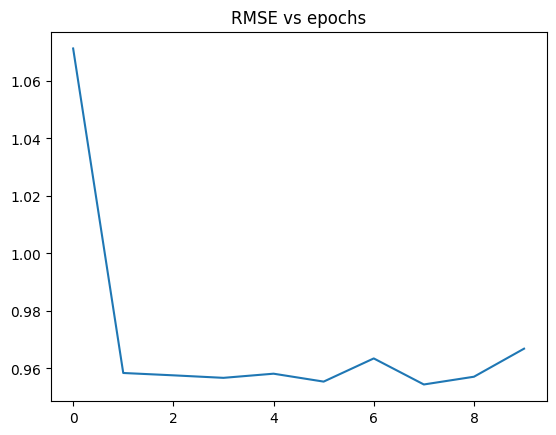

In [82]:
plt.plot(rmses)
plt.title('RMSE vs epochs')
plt.show()

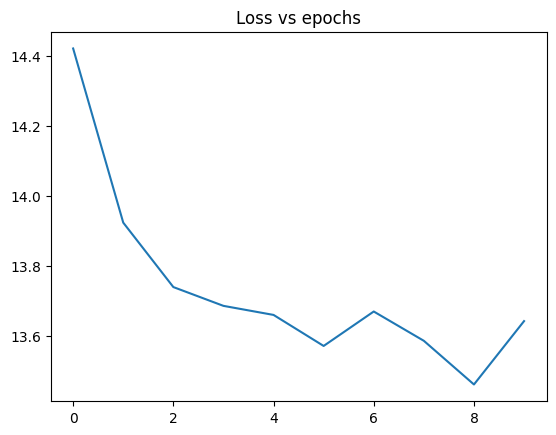

In [83]:
plt.plot(losses)
plt.title('Loss vs epochs')
plt.show()

In [84]:
%%script false --no-raise-error
fig, ax = plt.subplots()
artists = []

N, nb_feats = Xtrain.shape
X_ = torch.FloatTensor(Xz)
S_ = torch.FloatTensor(S)
batch_size = 100
epochs = 20
model = notMIWAE(input_size=nb_feats, n_samples=21)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x = torch.linspace(-2,2,100)

# with torch.no_grad():
#     logits = model.logits(x.unsqueeze(-1).expand(x.size() + torch.Size([nb_feats])))
#     p_s_given_x = np.array(torch.sigmoid(logits))
#     artists.append(ax.plot(x,p_s_given_x,label = [str(i) for i in range(11)]))
# plt.legend(loc = 'lower left')


y_datas = list()

for epoch in range(epochs):
    print(f'Epochs:{epoch+1}')
    p = np.random.permutation(N)
    X_ = X_[p,:]
    S_ = S_[p,:]
    
    for i in range(0,N,batch_size):
        print(f'{i+batch_size} / {N}', end="\r")
        X_batch = X_[i:(i+batch_size)]
        S_batch = S_[i:(i+batch_size)]

        if torch.isnan(X_batch).any().item():
                print('NaN X_batch')
        if torch.isnan(S_batch).any().item():
                print('NaN S_batch')
                
        elbo = model.elbo2(X_batch,S_batch)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        for param in model.parameters():
            if torch.isnan(param).any().item():
                print('NaN parameter')
                print(torch.isnan(param).any().item())
    with torch.no_grad():
        logits = model.logits(x.unsqueeze(-1).expand(x.size() + torch.Size([nb_feats])))
        p_s_given_x = np.array(torch.sigmoid(logits))
        y_datas.append(p_s_given_x)   

                
    
    print('loss', model.elbo2(X_,S_).item())







Couldn't find program: 'false'


In [85]:
# Enable interactive plots in Jupyter notebook
%matplotlib notebook

In [86]:
y_datas = np.array(y_datas)
# Function to update the plot in each animation frame
def update(frame):
    for i in range(len(lines)):
        lines[i].set_ydata(y_datas[frame,:,i])
    return lines

# Create a figure and axis
fig, ax = plt.subplots()
x = torch.linspace(-2,2,100)

with torch.no_grad():
    logits = model.logits(x.unsqueeze(-1).expand(x.size() + torch.Size([nb_feats])))
    p_s_given_x = np.array(torch.sigmoid(logits))
    lines = ax.plot(x,p_s_given_x,label = [str(i) for i in range(11)])


# Add legend
ax.legend(loc = 'lower left')

# Create the animation
animation = FuncAnimation(fig, update, frames=range(y_datas.shape[0]), interval=50, blit=True)

# Show the animated plot
plt.title("p(x|s)")
HTML(animation.to_jshtml())


<IPython.core.display.Javascript object>

We observe that the missing model is able to learn the missing pattern we chose.

## Experiments


## Load datasets

In [87]:
# %pip install ucimlrepo

In [88]:
from ucimlrepo import fetch_ucirepo 

In [89]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
wine_quality_df = wine_quality.data.original.drop('quality',axis = 1)

red_wine_quality_df = wine_quality_df.loc[wine_quality_df['color'] == 'red'].drop('color',axis = 1)
white_wine_quality_df = wine_quality_df.loc[wine_quality_df['color'] == 'white'].drop('color',axis = 1)

display(wine_quality_df.head())

X_red = red_wine_quality_df.to_numpy()
X_white = white_wine_quality_df.to_numpy()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red


In [90]:
# fetch dataset 
yeast = fetch_ucirepo(id=110) 
  
# data (as pandas dataframes) 
yeast_df = yeast.data.features
display(yeast_df.head())

X_yeast = np.array(yeast_df)

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


In [91]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
breast_cancer_df = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

display(breast_cancer_df.head())
X_breast = np.array(yeast_df)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [92]:
banknote_df = pd.read_csv('datasets\data_banknote_authentication.txt', low_memory=False, sep=',')
X_banknote = np.array(banknote_df)
X_banknote = X_banknote[:,:-1]
display(banknote_df.head())

,3.6216,8.6661,-2.8073,-0.44699,0
0,4.54590,8.1674,-2.4586,-1.46210,0
1,3.86600,-2.6383,1.9242,0.10645,0
2,3.45660,9.5228,-4.0112,-3.59440,0
3,0.32924,-4.4552,4.5718,-0.98880,0
4,4.36840,9.6718,-3.9606,-3.16250,0


In [93]:
# %pip install xlrd

In [94]:
concrete_df = pd.read_excel('datasets\Concrete_Data.xls')
X_concrete = np.array(concrete_df)
# X_concrete = X_concrete[:,:-1]
display(concrete_df.head())

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### Evaluation

In [95]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


def introduce_missing(X):
    N, D = X.shape
    Xnan = X.copy()

    # ---- MNAR in D/2 dimensions
    mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
    ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean
    Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz

def cross_val(data, runs = 5, missing_pattern = introduce_missing ):
    # ---- standardize data
    data = data - np.mean(data, axis=0)
    data = data / np.std(data, axis=0)


    Xtrain = data.copy()
    Xval_org = data.copy()

    RMSE_miwae = []
    RMSE_notmiwae = []
    RMSE_mean = []
    RMSE_median = []
    RMSE_mice = []
    RMSE_RF = []

    N, D = data.shape

    dl = D - 1

    n_hidden = 128
    n_samples = 20
    max_iter = 100000
    batch_size = 16
    epochs = min(max_iter * batch_size // N ,100)
    print(f'epochs = {epochs}')
    L = 10000
    for _ in range(runs):
        
        # ---- introduce missing process
        Xnan, Xz =  missing_pattern(Xtrain)
        S = np.array(~np.isnan(Xnan), dtype=float)
        Xval, Xvalz =  missing_pattern(Xval_org)

        # # ------------------- #
        # # ---- fit MIWAE ---- #
        # # ------------------- #
        # miwae = MIWAE(Xnan, Xval, n_latent=dl, n_samples=n_samples, n_hidden=n_hidden, name=name)
        miwae = notMIWAE(input_size=D, n_latent=dl, n_samples=n_samples,loss = MIWAE)

        # # ---- do the training
        # trainer.train(miwae, batch_size=batch_size, max_iter=max_iter, name=name + 'miwae')
        miwae.fit(Xz,S, lr=0.001, epochs=epochs)

        # # ---- find imputation RMSE
        # RMSE_miwae.append(utils.imputationRMSE(miwae, Xtrain, Xz, Xnan, S, L)[0])
        RMSE_miwae.append(miwae.rmse_imputation_miwae(Xtrain,Xz,S)[0]) # ok

        # # ---------------------- #
        # # ---- fit not-MIWAE---- #
        # # ---------------------- #
        # notmiwae = notMIWAE(Xnan, Xval, n_latent=dl, n_samples=n_samples, n_hidden=n_hidden, missing_process=mprocess, name=name)
        notmiwae = notMIWAE(input_size=D, n_latent=dl, n_samples=n_samples)#, loss = NOTMIWAE)

        
        # # ---- do the training
        # trainer.train(notmiwae, batch_size=batch_size, max_iter=max_iter, name=name + 'notmiwae')
        # notmiwae.fix_x_sigma = True 
        # notmiwae.fit(Xz,S, lr=0.1, epochs=epochs)
        # notmiwae.fix_x_sigma = False 
        notmiwae.fit(Xz,S, lr=0.001, epochs=epochs,batch_size=batch_size)

        # # ---- find imputation RMSE
        # RMSE_notmiwae.append(utils.not_imputationRMSE(notmiwae, Xtrain, Xz, Xnan, S, L)[0])
        RMSE_notmiwae.append(notmiwae.rmse_imputation(Xtrain,Xz,S,nb_samples=1_000)[0])

        # ------------------------- #
        # ---- mean imputation ---- #
        # ------------------------- #
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(Xnan)
        Xrec = imp.transform(Xnan)
        RMSE_mean.append(np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S)))

        # ------------------------- #
        # ---- median imputation ---- #
        # ------------------------- #
        imp = SimpleImputer(missing_values=np.nan, strategy='median')
        imp.fit(Xnan)
        Xrec = imp.transform(Xnan)
        RMSE_median.append(np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S)))

    print(f"RMSE_notmiwae : {RMSE_notmiwae}")
    print("RMSE_miwae = {0:.5f} +- {1:.5f}".format(np.mean(RMSE_miwae), np.std(RMSE_miwae)))
    print("RMSE_notmiwae = {0:.5f} +- {1:.5f}".format(np.mean(RMSE_notmiwae), np.std(RMSE_notmiwae)))
    print("RMSE_mean = {0:.5f} +- {1:.5f}".format(np.mean(RMSE_mean), np.std(RMSE_mean)))
    print("RMSE_median = {0:.5f} +- {1:.5f}".format(np.mean(RMSE_median), np.std(RMSE_median)))
    # print("RMSE_mice = {0:.5f} +- {1:.5f}".format(np.mean(RMSE_mice), np.std(RMSE_mice)))
    # print("RMSE_missForest = {0:.5f} +- {1:.5f}".format(np.mean(RMSE_RF), np.std(RMSE_RF)))

    

In [96]:
cross_val(X_white,runs = 1)

epochs = 100


RMSE_notmiwae : [tensor(1.4095)]
RMSE_miwae = 1.52046 +- 0.00000
RMSE_notmiwae = 1.40948 +- 0.00000
RMSE_mean = 1.73928 +- 0.00000
RMSE_median = 1.69429 +- 0.00000


In [97]:
cross_val(X_red,runs = 1)

epochs = 100
RMSE_notmiwae : [tensor(1.4809)]
RMSE_miwae = 1.62416 +- 0.00000
RMSE_notmiwae = 1.48088 +- 0.00000
RMSE_mean = 1.83821 +- 0.00000
RMSE_median = 1.84341 +- 0.00000


In [98]:
cross_val(X_breast,runs = 1)

epochs = 100
RMSE_notmiwae : [tensor(1.7038)]
RMSE_miwae = 1.66695 +- 0.00000
RMSE_notmiwae = 1.70380 +- 0.00000
RMSE_mean = 1.72853 +- 0.00000
RMSE_median = 1.62131 +- 0.00000


In [99]:
cross_val(X_concrete,runs = 1)

epochs = 100
RMSE_notmiwae : [tensor(2.7633)]
RMSE_miwae = 1.65898 +- 0.00000
RMSE_notmiwae = 2.76329 +- 0.00000
RMSE_mean = 1.84661 +- 0.00000
RMSE_median = 1.85660 +- 0.00000


In [100]:
cross_val(X_banknote,runs = 1)

epochs = 100
RMSE_notmiwae : [tensor(1.6335)]
RMSE_miwae = 1.27227 +- 0.00000
RMSE_notmiwae = 1.63352 +- 0.00000
RMSE_mean = 1.72561 +- 0.00000
RMSE_median = 1.62456 +- 0.00000
